# By-phone error rates: Buckeye test set
This computes and compares error rates at the phone level across different models' predicted transcriptions in the Buckeye test set. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.

In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phonecodes import phonecode_tables
import seaborn as sns

from multipa.evaluation import ModelEvaluator, PREDICTION_KEY, compute_error_rate_confidence_intervals_df
from multipa.visualization import plot_error_rates_by_phone_and_model

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DETAILED_EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
# These are the models we're actually interested in evaluating in detail
DETAILED_EVAL_CSVS = [
    # Models trained on full 20K samples (full dataset but gender balanced)
    "data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Models trained on entire dataset
    "ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Third party comparison models
    #"openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    #"facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv"
]

REFERENCE_COL = "ipa"

VALID_BUCKEYE_PHONES = set(phonecode_tables._buckeye2ipa.values())

# This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
BUCKEYE_VOWELS = set(["ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "ɹ̩", "eɪ", "ɪ", "i", "oʊ", "ɔɪ", "ʊ", "u", "æ̃", "ɔ̃",
                  "ə̃", "ĩ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ɑ̃", "ũ", "ɾ̃", "ə", "ɛ̃", "ʊ̃", "ãʊ̃", "ʌ̃", "ɪ̃", "ɹ̩̃", "ɔ̃ɪ̃"])

BUCKEYE_CONSONANTS = VALID_BUCKEYE_PHONES - BUCKEYE_VOWELS

# I'm just being picky about plot colors
HUE_ORDER = ["full_dataset_train", "train_duration_20000_samples", "openai_whisper-medium.en_to_epitran", "allosaurus_eng2102_eng", "facebook_wav2vec2-lv-60-espeak-cv-ft", "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns"]

HUE_ORDER_INDEX = {key: i for i, key in enumerate(HUE_ORDER)}

PALETTE = "colorblind"

sns.set_palette(PALETTE)

def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, VALID_BUCKEYE_PHONES)

def get_model_group(model_name):
    for p in ["train_duration_20000_samples", "full_dataset_train"]:
        if model_name.startswith(p):
            return p
    return model_name



/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in model results and re-generate comparison metrics
MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":buckeye_merge_func})

for csv in DETAILED_EVAL_CSVS:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()
    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    latest_ref_col = model_results[REFERENCE_COL]
    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)


Processing data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_5_

In [3]:
# Sanity check token counts against actual vocabulary
# The invalid token warnings are harmless, it's just removing some "NOISE" and disfluency markers that snuck through
# data preprocessing, but don't affect training
final_token_counts = {t:0 for t in VALID_BUCKEYE_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref, diphthongs=True, merge = buckeye_merge_func))

test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_BUCKEYE_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

display(token_counts_df)

REMOVING INVALID TOKEN: õ b'o\\u0303'
REMOVING INVALID TOKEN: O b'O'
REMOVING INVALID TOKEN: I b'I'
REMOVING INVALID TOKEN: E b'E'
REMOVING INVALID TOKEN: A b'A'
REMOVING INVALID TOKEN: U b'U'
REMOVING INVALID TOKEN: H b'H'


,phone,counts
55,ʌ,14477
16,ɪ,12433
46,n,9310
32,s,8389
39,ɛ,6829
48,i,6631
62,t,6465
17,ɹ,6185
36,k,5349
21,l,5348


In [4]:
# Munge data into dataframe format for analysis
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_BUCKEYE_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

all_error_rates_df = compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")

In [5]:
display(all_error_rates_df.head())

,model_name,phone,err_rate,model_group,counts,confidence_interval
0,train_duration_20000_samples_1,f,0.084753,train_duration_20000_samples,2348,0.011266
1,train_duration_20000_samples_2,f,0.116269,train_duration_20000_samples,2348,0.012966
2,train_duration_20000_samples_3,f,0.078790,train_duration_20000_samples,2348,0.010897
3,train_duration_20000_samples_4,f,0.076235,train_duration_20000_samples,2348,0.010734
4,train_duration_20000_samples_5,f,0.087308,train_duration_20000_samples,2348,0.011418


<Axes: title={'center': 'Error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

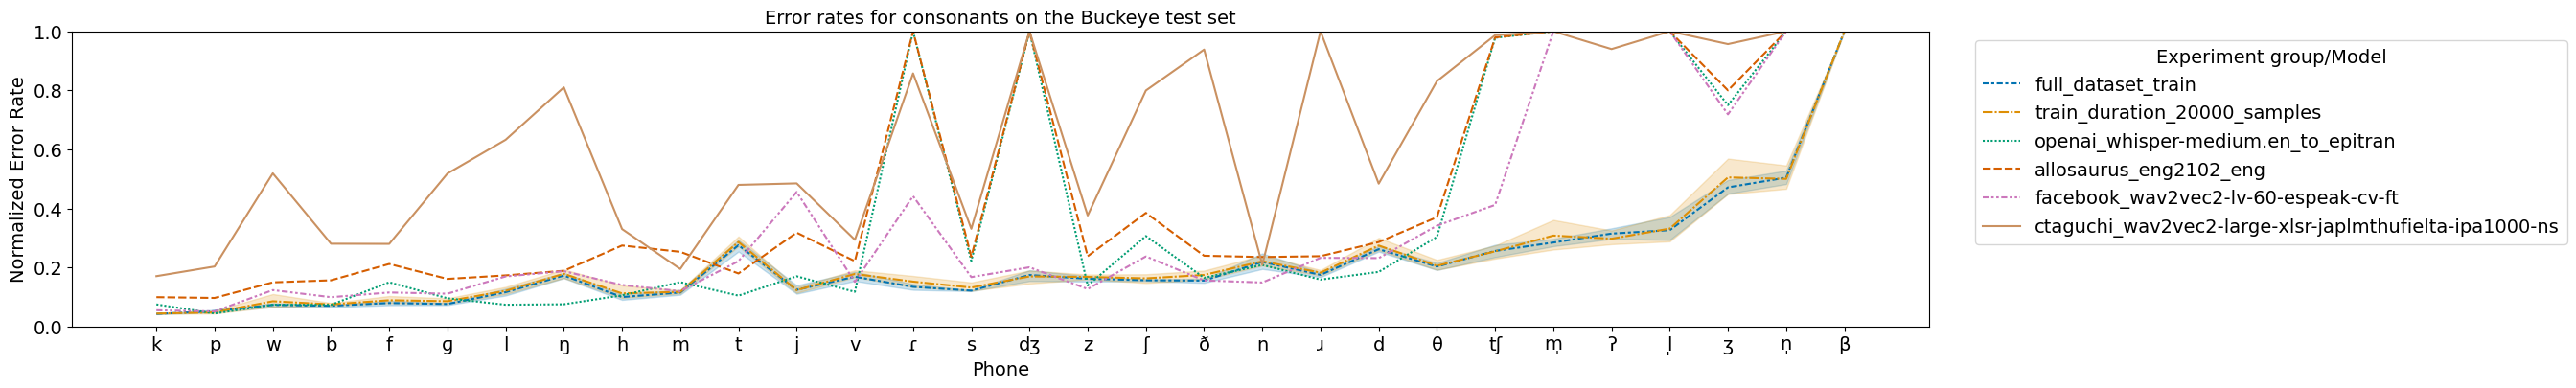

In [6]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(consonant_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'Error rates for vowels on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

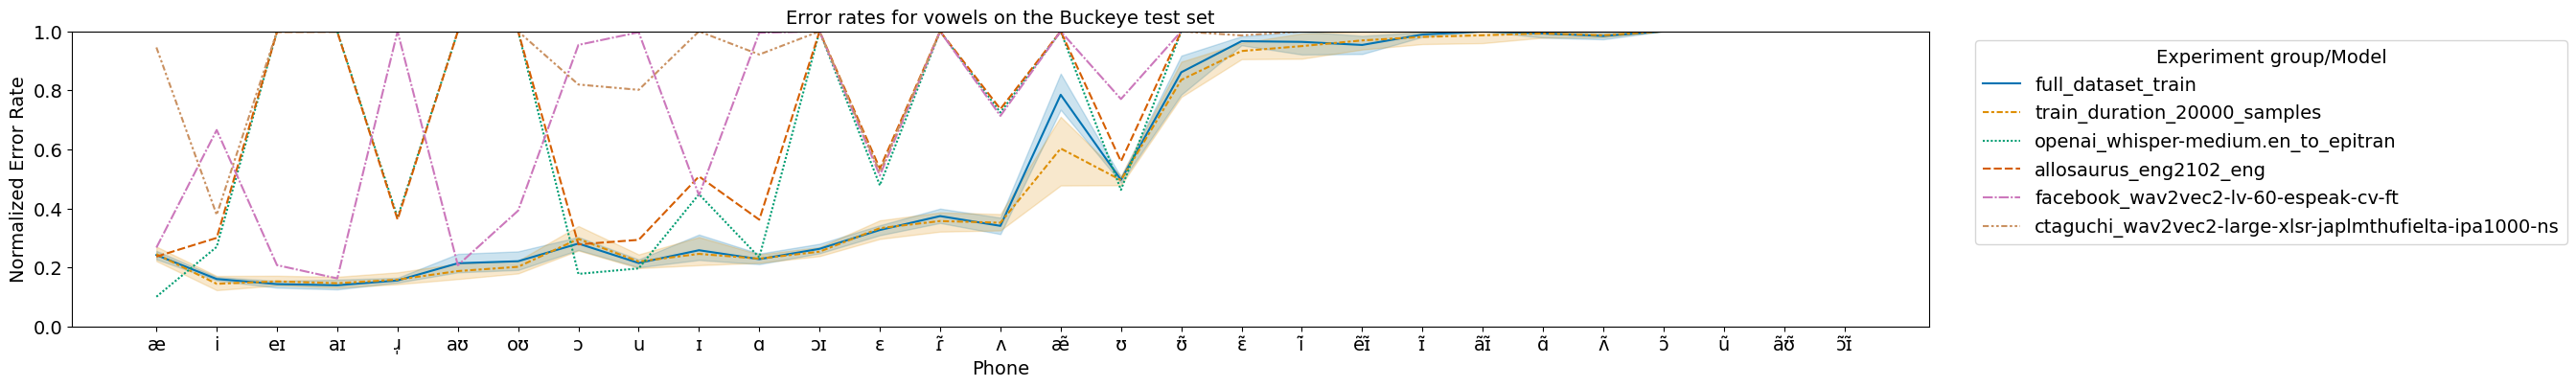

In [7]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(vowel_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for vowels on the Buckeye test set")

In [8]:
our_models = all_error_rates_df[all_error_rates_df["model_group"].isin(["train_duration_20000_samples", "full_dataset_train"])]
model_orders = [f"train_duration_20000_samples_{i}" for i in range(1, 6)] + [f"full_dataset_train_{i}" for i in range(1, 6)]

<Axes: title={'center': 'AutoIPA model error rates for consonants on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

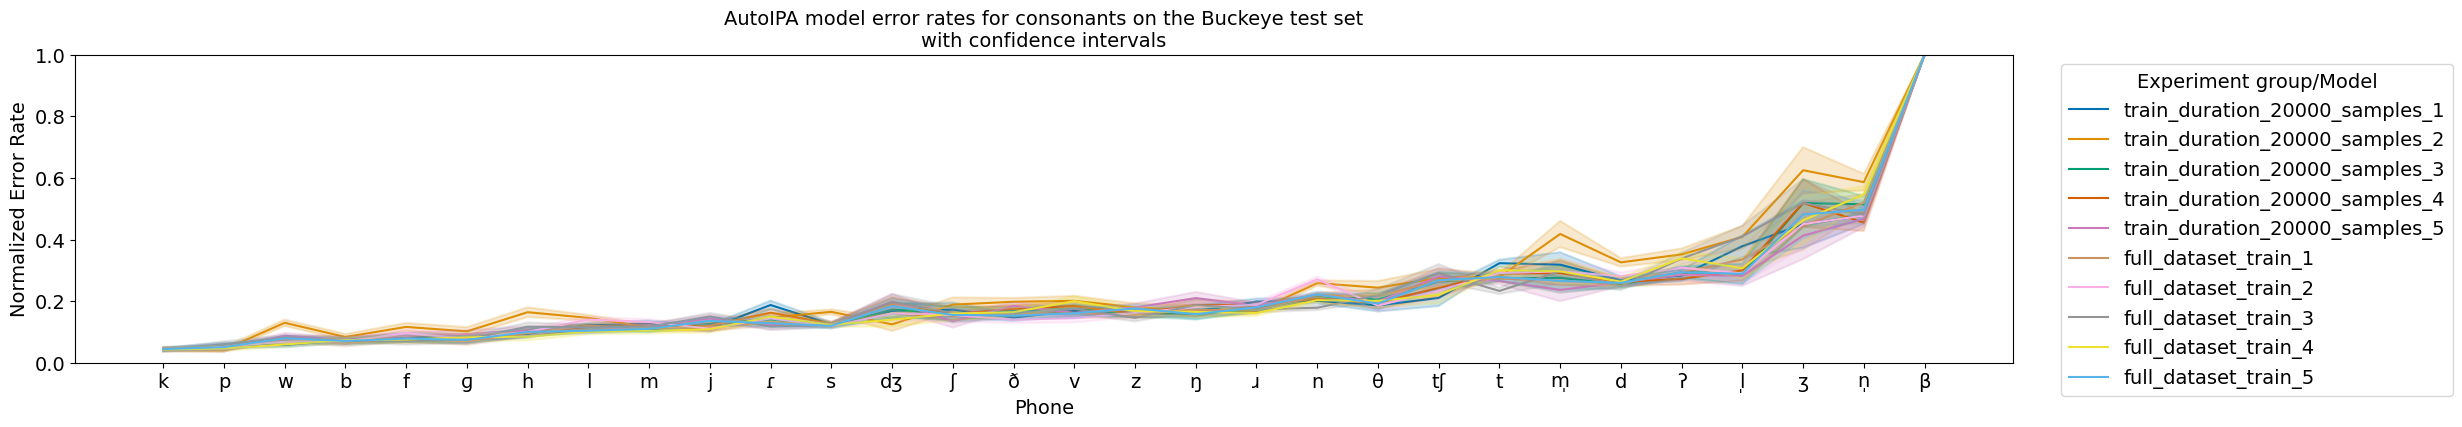

In [9]:
our_models_consonants = our_models[our_models["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for consonants on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True)

<Axes: title={'center': 'AutoIPA model error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

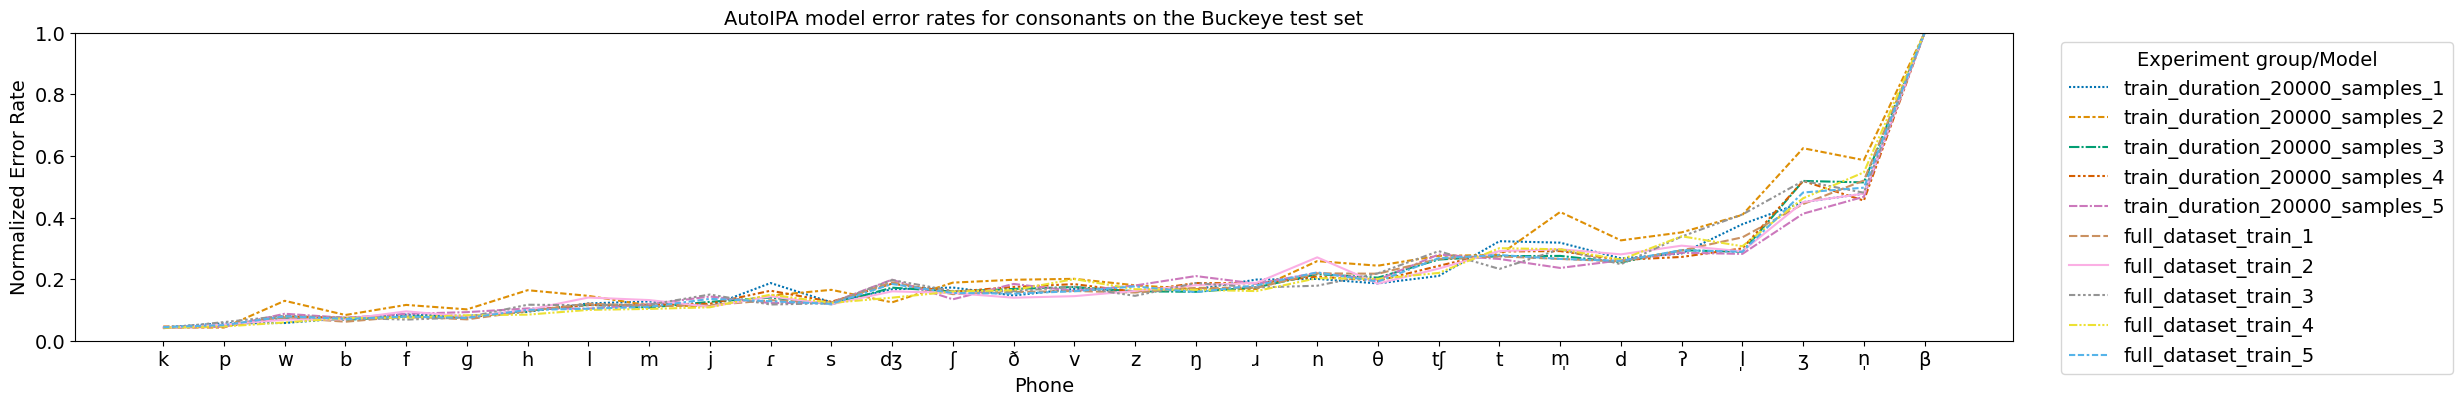

In [10]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'AutoIPA model error rates for vowels on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

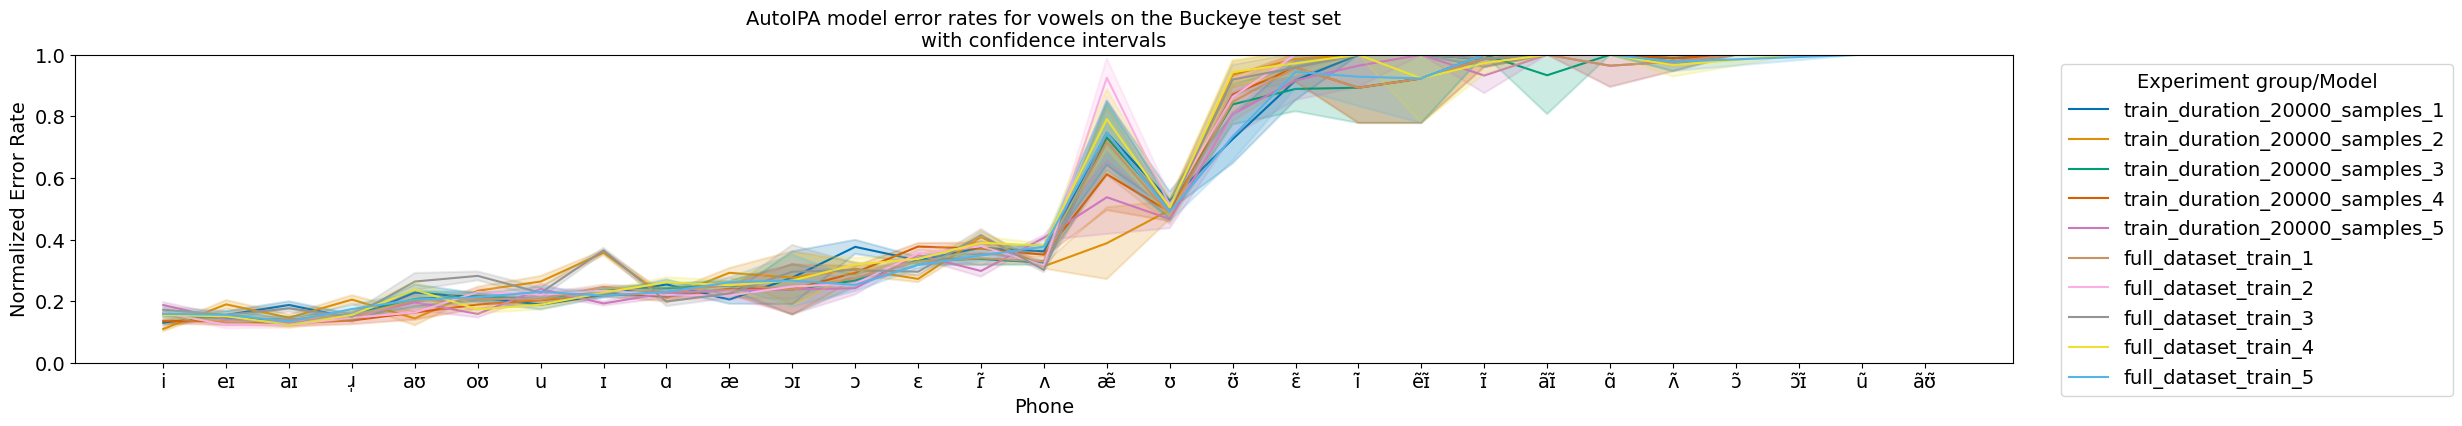

In [11]:
our_models_vowels = our_models[our_models["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for vowels on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True, )

In [12]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", hue_order=HUE_ORDER, palette=PALETTE, title="AutoIPA model error rates for vowels on the Buckeye test set", hue_order = model_orders)

SyntaxError: keyword argument repeated: hue_order (2312825774.py, line 1)

In [ ]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_group",  hue_order=["full_dataset_train", "train_duration_20000_samples"], palette=PALETTE, title="Error rates for consonants on the Buckeye test\naveraged across AutoIPA experiment groups",)

In [ ]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_group", hue_order=["full_dataset_train", "train_duration_20000_samples"], palette=PALETTE, title="Error rates for vowels on the Buckeye test\naveraged across AutoIPA experiment groups",)